In [1]:
# env: esm1
import torch
import esm
import pandas as pd
from tqdm import tqdm
from Bio import SeqIO

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
# model.eval().to(device)

Using device: cuda


In [7]:
# Check for duplicate rows in tb_df
duplicate_rows = tb_df[tb_df.duplicated()]
print("Number of duplicate rows:", duplicate_rows.shape[0])
if not duplicate_rows.empty:
    print(duplicate_rows)
else:
    print("No duplicate rows found.")

# Alternatively, check for duplicate sequences specifically
duplicate_sequences = tb_df[tb_df.duplicated(subset="Sequences")]
print("Number of duplicate sequences:", duplicate_sequences.shape[0])
if not duplicate_sequences.empty:
    print(duplicate_sequences)
else:
    print("No duplicate sequences found.")

Number of duplicate rows: 0
No duplicate rows found.
Number of duplicate sequences: 0
No duplicate sequences found.


In [5]:

# Load ESM-1b model and alphabet
model, alphabet = esm.pretrained.esm1b_t33_650M_UR50S()
batch_converter = alphabet.get_batch_converter()
model.eval().cuda()  # Use GPU if available

# Example: sequences to embed
# Replace this with your DataFrame or sequence list
# df = pd.read_csv("your_sequences.csv")
# sequences = df["Sequences"].tolist()
sequences = [str(record.seq) for record in SeqIO.parse("/mnt/storageG1/lwang/Projects/TB-AMP-design/models/generated_peptides.fasta", "fasta")]

# Prepare data: ESM expects list of (name, sequence) tuples
data = [(f"seq{i}", seq) for i, seq in enumerate(sequences)]

# Batch encode and extract embeddings
all_embeddings = []

with torch.no_grad():
    for i in tqdm(range(0, len(data), 8)):  # small batches if memory constrained
        batch_data = data[i:i+8]
        labels, strs, tokens = batch_converter(batch_data)
        tokens = tokens.cuda()

        # Extract representations from the final layer
        results = model(tokens, repr_layers=[33], return_contacts=False)
        token_representations = results["representations"][33]

        for j, (_, seq) in enumerate(batch_data):
            # Extract per-sequence embedding: mean of all token embeddings (excluding special tokens)
            emb = token_representations[j, 1:len(seq)+1].mean(0)  # shape: (1280,)
            all_embeddings.append(emb.cpu().numpy())

# Convert to DataFrame
embedding_df = pd.DataFrame(all_embeddings)
embedding_df["sequence"] = sequences

# Save if needed
# embedding_df.to_csv("esm1b_embeddings.csv", index=False)

print("✅ ESM-1b embeddings generated and saved.")


100%|██████████| 13/13 [00:01<00:00, 11.53it/s]

✅ ESM-1b embeddings generated and saved.


100%|██████████| 38/38 [03:27<00:00,  5.45s/it]


Explained variance by first 50 components: 0.92


/mnt/storageG1/lwang/miniconda3/envs/esm1/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


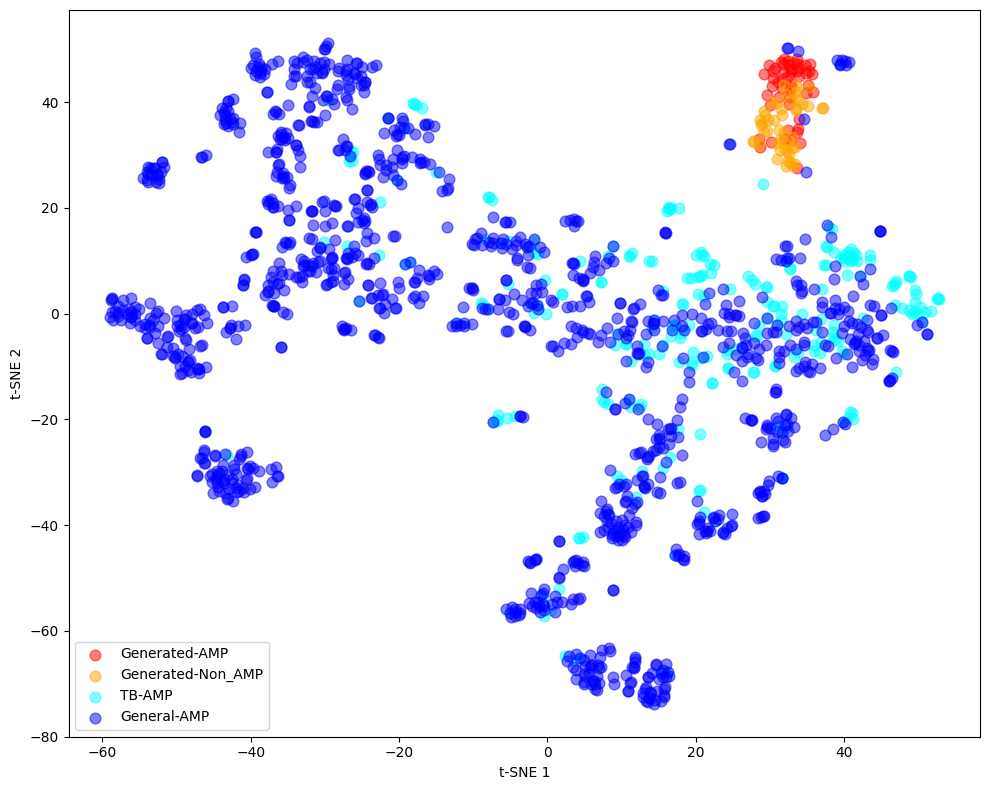

In [ ]:
import torch
import esm
import pandas as pd
from tqdm import tqdm
from Bio import SeqIO
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Load ESM-1b model
model, alphabet = esm.pretrained.esm1b_t33_650M_UR50S()
batch_converter = alphabet.get_batch_converter()
model.eval()

def extract_esm_embeddings(sequence_list, label_prefix, batch_size=32):
    data = [(f"{label_prefix}{i}", seq) for i, seq in enumerate(sequence_list)]
    embeddings = []
    labels = []

    with torch.no_grad():
        for i in tqdm(range(0, len(data), batch_size)):
            batch_data = data[i:i+batch_size]
            labels_batch, strs, tokens = batch_converter(batch_data)
            results = model(tokens, repr_layers=[33], return_contacts=False)
            token_representations = results["representations"][33]

            for j, (_, seq) in enumerate(batch_data):
                emb = token_representations[j, 1:len(seq)+1].mean(0)
                embeddings.append(emb.cpu().numpy())
                labels.append(label_prefix)

    return embeddings, labels

# Load generated sequences
generated_sequences = [str(record.seq) for record in SeqIO.parse(
    "/mnt/storageG1/lwang/Projects/TB-AMP-design/models/1745346340796_AMPCandidates0.7-pos.fa", "fasta")]
gen_embeddings_pos, gen_labels_pos = extract_esm_embeddings(generated_sequences, "Generated-AMP")

generated_sequences = [str(record.seq) for record in SeqIO.parse(
    "/mnt/storageG1/lwang/Projects/TB-AMP-design/models/1745346340796_AMPCandidates0.7-neg.fa", "fasta")]
gen_embeddings_neg, gen_labels_neg = extract_esm_embeddings(generated_sequences, "Generated-Non_AMP")


# Load reference AMP sequences
ref_df = pd.read_csv("../data/all_seq702.csv")
ref_df = ref_df.drop_duplicates(subset='Sequences')

df_filtered = ref_df

def split_sequence(seq, chunk_size=20):
    return [seq[i:i+chunk_size] for i in range(0, len(seq), chunk_size)]

new_rows = []
for _, row in df_filtered.iterrows():
    seq = row['Sequences']
    amp_label = row['AMP']
    if len(seq) > 40:
        for chunk in split_sequence(seq, 20):
            new_rows.append({'Sequences': chunk, 'AMP': amp_label})
    else:
        new_rows.append({'Sequences': seq, 'AMP': amp_label})

df_filtered = pd.DataFrame(new_rows)
ref_df = df_filtered
ref_df = ref_df[
    (ref_df['Sequences'].str.len() >= 10) &
    (ref_df['Sequences'].apply(lambda x: len(set(x)) > 1)) &
    (~ref_df['Sequences'].str.contains('X'))
]
ref_df = ref_df.loc[ref_df['AMP'] == 1, :]
reference_sequences = ref_df["Sequences"].tolist()
ref_embeddings, ref_labels = extract_esm_embeddings(reference_sequences, "TB-AMP")

################

adam_df = pd.read_csv("../data/naturalAMPs_APD2024a-ADAM.csv")
adam_df.columns = ['Peptide ID', 'Sequences']
adam_df = adam_df.drop_duplicates(subset='Sequences')
adam_df = adam_df[~adam_df['Sequences'].isin(ref_df['Sequences'])]
filtered_adam_df = adam_df[
    (adam_df['Sequences'].str.len() >= 10) &
    (adam_df['Sequences'].str.len() <= 40)
].reset_index(drop=True)

adam_df = filtered_adam_df[:1200]
reference_sequences = adam_df["Sequences"].tolist()
general_embeddings, general_labels = extract_esm_embeddings(reference_sequences, "General-AMP")


# Combine and reduce
all_embeddings = gen_embeddings_pos + gen_embeddings_neg +ref_embeddings + general_embeddings
all_labels = gen_labels_pos + gen_labels_neg +ref_labels + general_labels

pca_model = PCA(n_components=50)
pca_result = pca_model.fit_transform(all_embeddings)

# Calculate how much variance is explained by the first 50 components
explained_variance_50d = np.sum(pca_model.explained_variance_ratio_)
print(f"Explained variance by first 50 components: {explained_variance_50d:.2f}")
# Apply t-SNE on the PCA result
tsne = TSNE(n_components=2, perplexity=30, n_iter=3000, random_state=42).fit_transform(pca_result)

# Plot using matplotlib
vis_df = pd.DataFrame(tsne, columns=["x", "y"])
vis_df["Source"] = all_labels

colors = {
    "Generated-AMP": "red",
    "Generated-Non_AMP": "orange",
    "TB-AMP": "cyan",
    "General-AMP": "blue"
}
plt.figure(figsize=(10, 8))
for label in vis_df["Source"].unique():
    subset = vis_df[vis_df["Source"] == label]
    plt.scatter(subset["x"], subset["y"], label=label, alpha=0.5, s=60, c=colors[label])

# plt.title("t-SNE of ESM-1b Embeddings: Generated vs Reference AMPs")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend()
plt.tight_layout()
plt.show()


In [18]:
explained_variance_50d

np.float64(0.9306798917264013)